In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

#import custom modules
import sys
sys.path.insert(0, '/Users/frederickkorbel/Documents/projects/paper/mlcis/utils')

import integrated_gradients as ig
import metaplot

#set seaborn style
sns.set_style('ticks')

In the following cell, we adapt functions from Sample et. al (2019) to train and test models

In [1]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0.2, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Here, we keep additional code for generating a training history diagram in case we need it.

In [4]:
#define a class to record training history as keras callback
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

history = LossHistory()

#custom training function that records loss on training and test (validation) datasets
def train_model_with_history(x, y, test_seq, test, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0.2, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1, validation_data=(test_seq, test), callbacks = [history])
    return model

# plot the previously recorded training history to diagnose model training behavior
def plot_history(model, title='Training History'):
    model_loss = pd.DataFrame(model.history.history)

    fig = plt.figure()
    a = model_loss['loss']
    b = model_loss['val_loss']
    c = np.array(range(1,len(model_loss['loss'])+1,1))
    axes = fig.add_axes([0.0, 0.0, 0.8, 0.8])
    axes.plot(c, a, label='training loss')
    axes.plot(c, b, label='validation loss')
    axes.set_xlim(0, len(model_loss['loss']) + 1)
    axes.set_ylim(0, 1)
    axes.legend(loc=3)
    axes.set(xlabel = 'epoch', ylabel='loss',
             title = title)

We train the MRL model architecture on the human library and validate

Epoch 1/9
157/157 [==============================] - 33s 205ms/step - loss: 0.9102
Epoch 2/9
157/157 [==============================] - 38s 243ms/step - loss: 0.3887
Epoch 3/9
157/157 [==============================] - 28s 181ms/step - loss: 0.3038
Epoch 4/9
157/157 [==============================] - 30s 191ms/step - loss: 0.2663
Epoch 5/9
157/157 [==============================] - 31s 200ms/step - loss: 0.2510
Epoch 6/9
157/157 [==============================] - 40s 256ms/step - loss: 0.2303
Epoch 7/9
157/157 [==============================] - 33s 210ms/step - loss: 0.1988
Epoch 8/9
157/157 [==============================] - 30s 189ms/step - loss: 0.1655
Epoch 9/9
157/157 [==============================] - 28s 175ms/step - loss: 0.1513
r-squared =  0.8005493284758706


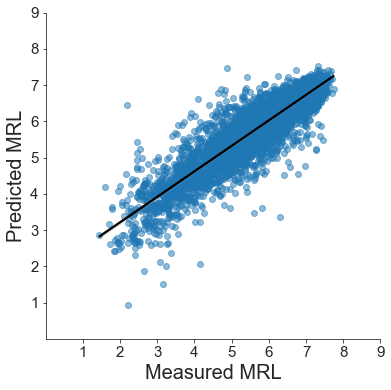

In [10]:
#import data
e_train=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_train.csv')
e_test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv')

#one-hot-encode
seq_e_train= metaplot.one_hot_encode(e_train, seq_len=50)
seq_e_test= metaplot.one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

#train model
hmrl_model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=9,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#test model
e_test = test_data(df=e_test, model=hmrl_model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print('r-squared = ', r)

#plot correlation between measured and predicted MRL
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = e_test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

We save the model and predictions of the model trained on human utrs (referred to as hMRL) for interpretation

In [11]:
#save trained hMRL model
hmrl_model.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model.hdf5')

#save predictions to csv
e_test.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_human_test_pred.csv')

We import the main model from Sample et. al (2019), predict MRL for the test set of synthetic utrs and save predictions

r-squared =  0.9338504472817784


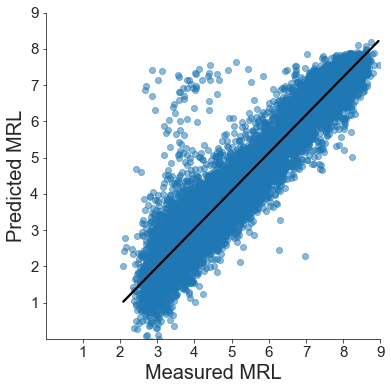

In [7]:
#import model
main_mrl_model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')

#import test set 
mrl_test = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv')
del mrl_test['Unnamed: 0']

#one-hot-encode utrs
mrl_seq_test = metaplot.one_hot_encode(mrl_test, seq_len=50)

#make predictions and save in a new column
mrl_test = test_data(df=mrl_test, model = main_mrl_model, obs_col = 'rl', test_seq=mrl_seq_test)

#plot performance
r_2 = r2(mrl_test['rl'], mrl_test['pred'])
print('r-squared = ', r_2)
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = mrl_test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

#save predictions to csv
mrl_test.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_random_test_pred.csv')

To reveal more subtle regulatory effects of sequence motifs in the utr, we train the model architecture exclusively on reporters that do not exhibit a start codon in their utr (-uAUG)

Again, we train the model on the synthetic library without uAUG-reporters and assess performance as well as save model predictions

In [5]:
#import data
train=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_train.csv.gz', compression='gzip')
test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv')

#remove utrs with uAUG
test = test[test['utr'].apply(lambda x: 'ATG' not in x)]
train = train[train['utr'].apply(lambda x: 'ATG' not in x)]

#check how many utrs are left in both datasets
print("There are ", len(test), " UTRs left in the test set.")
print("There are ", len(train), " UTRs left in the train set.")

There are  6014  UTRs left in the test set.
There are  122927  UTRs left in the train set.


Epoch 1/3
961/961 [==============================] - 151s 156ms/step - loss: 0.8055 - val_loss: 0.6974
Epoch 2/3
961/961 [==============================] - 129s 135ms/step - loss: 0.6389 - val_loss: 0.6572
Epoch 3/3
961/961 [==============================] - 177s 185ms/step - loss: 0.6263 - val_loss: 0.5885


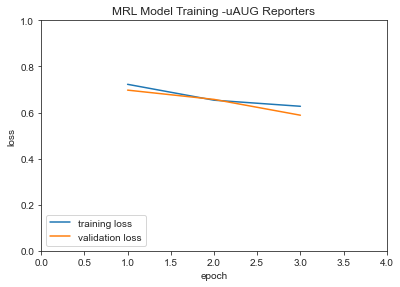

In [21]:
#one-hot-encode
seq_train= metaplot.one_hot_encode(train, seq_len=50)
seq_test= metaplot.one_hot_encode(test, seq_len=50)

# Scale the training mean ribosome load values
train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(train.loc[:,'rl'].values.reshape(-1,1))
test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(test.loc[:,'rl'].values.reshape(-1,1))

#train model with history callback
mrl_model_no_aug = train_model_with_history(seq_train, train['scaled_rl'], seq_test, test['scaled_rl'], nb_epoch=3,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#plot model training history
plot_history(mrl_model_no_aug, title='MRL Model Training -uAUG Reporters')

r-squared =  0.4217626283612108


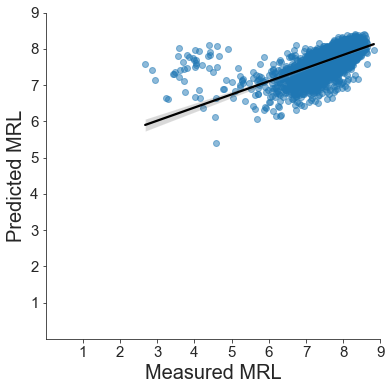

In [22]:
#test model
test = test_data(df=test, model=mrl_model_no_aug, obs_col='rl',test_seq=seq_test)
r = r2(test['rl'], test['pred'])
print('r-squared = ', r)

#plot correlation between measured and predicted MRL
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

In [24]:
#save MRL model trained without uAUG Reporters
mrl_model_no_aug.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_aug.hdf5')

#save predictions to csv
test.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_aug_random_test_pred.csv')

Secondly, we train the model architecture on human utrs exclusively without uAUGs, assess performance and save predictions for attribution

In [11]:
#import data
h_train=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_train.csv')
h_test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv')

#remove utrs with uAUG
h_test = h_test[h_test['utr'].apply(lambda x: 'ATG' not in x)]
h_train = h_train[h_train['utr'].apply(lambda x: 'ATG' not in x)]

#check how many utrs are left in both datasets
print("There are ", len(h_test), " UTRs left in the test set.")
print("There are ", len(h_train), " UTRs left in the train set.")

There are  3942  UTRs left in the test set.
There are  14564  UTRs left in the train set.


Epoch 1/7
114/114 [==============================] - 20s 162ms/step - loss: 0.6759 - val_loss: 0.4064
Epoch 2/7
114/114 [==============================] - 18s 158ms/step - loss: 0.4621 - val_loss: 0.3836
Epoch 3/7
114/114 [==============================] - 19s 164ms/step - loss: 0.4227 - val_loss: 0.3428
Epoch 4/7
114/114 [==============================] - 18s 162ms/step - loss: 0.4122 - val_loss: 0.3120
Epoch 5/7
114/114 [==============================] - 18s 162ms/step - loss: 0.3755 - val_loss: 0.3040
Epoch 6/7
114/114 [==============================] - 19s 168ms/step - loss: 0.3298 - val_loss: 0.3056
Epoch 7/7
114/114 [==============================] - 19s 166ms/step - loss: 0.2899 - val_loss: 0.2916


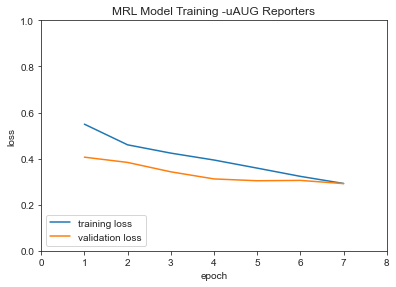

In [19]:
#one-hot-encode
seq_h_train= metaplot.one_hot_encode(h_train, seq_len=50)
seq_h_test= metaplot.one_hot_encode(h_test, seq_len=50)

# Scale the training mean ribosome load values
h_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_train.loc[:,'rl'].values.reshape(-1,1))
h_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_test.loc[:,'rl'].values.reshape(-1,1))

#train model with history callback
hmrl_model_no_aug = train_model_with_history(seq_h_train, h_train['scaled_rl'], seq_h_test, h_test['scaled_rl'], nb_epoch=7,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#plot model training history
plot_history(hmrl_model_no_aug, title='hMRL Model Training -uAUG Reporters')

r-squared =  0.7213436552246613


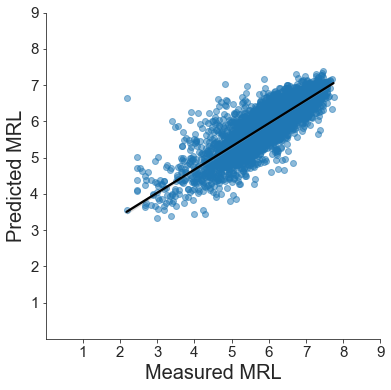

In [20]:
#test model
h_test = test_data(df=h_test, model=hmrl_model_no_aug, obs_col='rl',test_seq=seq_h_test)
r = r2(h_test['rl'], h_test['pred'])
print('r-squared = ', r)

#plot correlation between measured and predicted MRL
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = h_test, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

In [25]:
#save MRL model trained without on human utrs without uAUG
mrl_model_no_aug.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_aug.hdf5')

#save predictions to csv
h_test.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_aug_human_test_pred.csv')

Model interpretation revealed, that a 'TG' dinucleotide in the first two positions of a utr creates an artificial ATG codon with a PCR adapter which is falsely recognized by the neural network. Thus, the model learns 'TG' to be biologically relevant, although introduced only through experimental design.

This is why we further remove all utrs with 'TG' as their first two nucleotides and train the models with all remaining reporters to reveal biologically relevant motifs with attribution.

First, we do this for the synthetic dataset and model.

118525
5813
Epoch 1/3
926/926 [==============================] - 171s 184ms/step - loss: 0.6986 - val_loss: 0.5242
Epoch 2/3
926/926 [==============================] - 163s 177ms/step - loss: 0.5978 - val_loss: 0.5030
Epoch 3/3
926/926 [==============================] - 164s 177ms/step - loss: 0.5575 - val_loss: 0.5169


/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_1769/3181905933.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


r-squared =  0.40716822064537783


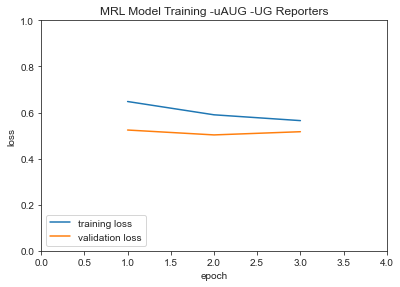

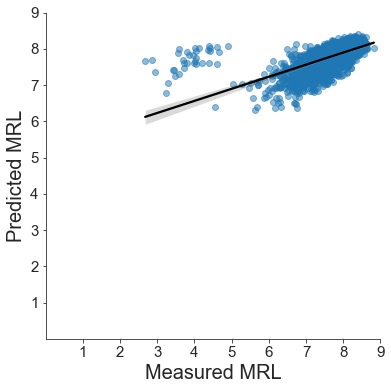

In [64]:
#remove utrs with 'TG' as first to nucleotides from training and test set of synthetic utrs
train_no_ug = train[train['utr'].apply(lambda x: x.startswith('TG')== False)]
print(len(train_no_ug))
test_no_ug = test[test['utr'].apply(lambda x: x.startswith('TG')== False)]
print(len(test_no_ug))

#train and test a model on the remaining sequences

#one-hot-encode
seq_train_no_ug= metaplot.one_hot_encode(train_no_ug, seq_len=50)
seq_test_no_ug= metaplot.one_hot_encode(test_no_ug, seq_len=50)

#train model with history callback
mrl_model_no_ug = train_model_with_history(seq_train_no_ug, train_no_ug['scaled_rl'], seq_test_no_ug, test_no_ug['scaled_rl'], nb_epoch=3,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#plot model training history
plot_history(mrl_model_no_ug, title='MRL Model Training -uAUG -UG Reporters')

#test model
test_no_ug = test_data(df=test_no_ug, model=mrl_model_no_ug, obs_col='rl',test_seq=seq_test_no_ug)
r = r2(test_no_ug['rl'], test_no_ug['pred'])
print('r-squared = ', r)

#plot correlation between measured and predicted MRL
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = test_no_ug, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()


In [76]:
#save MRL model trained without uAUG and UG Reporters
mrl_model_no_ug.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_ug.hdf5')

#save predictions to csv
test_no_ug.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_ug_random_test_pred.csv')

14079
3853


/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_1769/3219706037.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_train_no_ug.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_train_no_ug.loc[:,'rl'].values.reshape(-1,1))
/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_1769/3219706037.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_test_no_ug.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_test_no_ug.loc[:,'rl'].values.reshape(-1,1))


Epoch 1/7
110/110 [==============================] - 24s 207ms/step - loss: 0.6094 - val_loss: 0.3768
Epoch 2/7
110/110 [==============================] - 20s 179ms/step - loss: 0.4219 - val_loss: 0.3317
Epoch 3/7
110/110 [==============================] - 20s 182ms/step - loss: 0.4095 - val_loss: 0.3876
Epoch 4/7
110/110 [==============================] - 22s 201ms/step - loss: 0.3471 - val_loss: 0.2964
Epoch 5/7
110/110 [==============================] - 22s 199ms/step - loss: 0.3228 - val_loss: 0.2906
Epoch 6/7
110/110 [==============================] - 21s 189ms/step - loss: 0.3001 - val_loss: 0.2533
Epoch 7/7
110/110 [==============================] - 19s 173ms/step - loss: 0.2356 - val_loss: 0.2585


/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_1769/3181905933.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,output_col] = scaler.inverse_transform(predictions)


r-squared =  0.7496795492274189


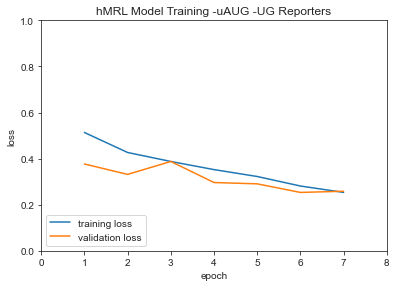

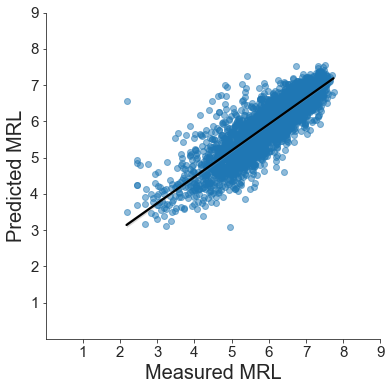

In [71]:
#remove utrs with 'TG' as first to nucleotides from training and test set of human utrs
h_train_no_ug = h_train[h_train['utr'].apply(lambda x: x.startswith('TG')== False)]
print(len(h_train_no_ug))
h_test_no_ug = h_test[h_test['utr'].apply(lambda x: x.startswith('TG')==False)]
print(len(h_test_no_ug))

#train and test a model on the remaining sequences

#one-hot-encode
seq_h_train_no_ug= metaplot.one_hot_encode(h_train_no_ug, seq_len=50)
seq_h_test_no_ug= metaplot.one_hot_encode(h_test_no_ug, seq_len=50)

#scale
h_train_no_ug.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_train_no_ug.loc[:,'rl'].values.reshape(-1,1))
h_test_no_ug.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(h_test_no_ug.loc[:,'rl'].values.reshape(-1,1))

#train model with history callback
tmrl_model_no_ug = train_model_with_history(seq_h_train_no_ug, h_train_no_ug['scaled_rl'], seq_h_test_no_ug, h_test_no_ug['scaled_rl'], nb_epoch=7,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

#plot model training history
plot_history(tmrl_model_no_ug, title='hMRL Model Training -uAUG -UG Reporters')

#test model
h_test_no_ug = test_data(df=h_test_no_ug, model=tmrl_model_no_ug, obs_col='rl',test_seq=seq_h_test_no_ug)
r = r2(h_test_no_ug['rl'], h_test_no_ug['pred'])
print('r-squared = ', r)

#plot correlation between measured and predicted MRL
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = h_test_no_ug, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()


In [77]:
#save MRL model trained without uAUG Reporters
tmrl_model_no_ug.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_ug.hdf5')

#save predictions to csv
h_test_no_ug.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_ug_human_test_pred.csv')

We create an overview of the dataset sizes before and after exclusion of uAUG and UG reporters.

In [4]:
#import all datasets
mrl_train=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_train.csv.gz', compression='gzip', index_col=[0])
mrl_test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])


test=mrl_test[mrl_test['utr'].apply(lambda x: 'ATG' not in x)]
train=mrl_train[mrl_train['utr'].apply(lambda x: 'ATG' not in x)]

train_no_ug=train[train['utr'].apply(lambda x: x.startswith('TG')== False)]
test_no_ug=test[test['utr'].apply(lambda x: x.startswith('TG')== False)]

#human datasets
e_train=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_train.csv', index_col=[0])
e_test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])

h_test=e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
h_train=e_train[e_train['utr'].apply(lambda x: 'ATG' not in x)]

h_train_no_ug=h_train[h_train['utr'].apply(lambda x: x.startswith('TG')== False)]
h_test_no_ug=h_test[h_test['utr'].apply(lambda x: x.startswith('TG')== False)]

#create dictionary with sample sizes of all datasets
dic={('synthetic', 'train'):[len(mrl_train),  len(train),  len(train_no_ug)],
    ('synthetic', 'test'):[len(mrl_test),  len(test),  len(test_no_ug)],
    ('human', 'train'):[len(e_train), len(h_train), len(h_train_no_ug)],
    ('human', 'test'):[len(e_test), len(h_test), len(h_test_no_ug)]}

#create a multi-indexed dataframe from the dictionary
sample_size_df=pd.DataFrame(data=dic, index=['ALL', 'no_uAUG', 'no_uAUG_UG'])
sample_size_df

synthetic         human      
               train   test  train  test
ALL           260000  20000  20000  5000
no_uAUG       122927   6014  14564  3942
no_uAUG_UG    118525   5813  14079  3853